## Install keras preprocessing and Imports

In [1]:
!pip install -U Keras-Preprocessing===1.1.0
from keras import preprocessing

     |████████████████████████████████| 51kB 4.7MB/s 
ERROR: tensorflow 2.4.0 has requirement keras-preprocessing~=1.1.2, but you'll have keras-preprocessing 1.1.0 which is incompatible.
  Found existing installation: Keras-Preprocessing 1.1.2
    Uninstalling Keras-Preprocessing-1.1.2:
      Successfully uninstalled Keras-Preprocessing-1.1.2


In [2]:
import os
import json
from io import BytesIO
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import backend as K
!nvidia-smi

Wed Dec 30 20:14:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load data dirs and unpack

In [3]:
from google.colab import drive
DRIVE_DIR = '/content/drive/My Drive'
drive.mount('/content/drive')
DATA_DIR = os.path.join(DRIVE_DIR,"SDD","WTBI")

PHOTOS_FILE = os.path.join(DATA_DIR,"photos","photos.txt")
photo_url_file = open(PHOTOS_FILE)
photo_urls = photo_url_file.readlines() 
photo_urls = [line.split(',') for line in photo_urls]
photo_urls = [ [int(line[0]),line[1]] for line in photo_urls]

JSON_DIR = os.path.join(DATA_DIR,"meta","meta","json")
classes = ["bags","belts","dresses","eyewear","footwear","hats","leggings","outerwear","pants","skirts","tops"]
ret_files = dict([(class_,json.load(open(os.path.join( JSON_DIR,"retrieval_"+class_+".json"  )))) for class_ in classes])
train_files = dict([(class_,json.load(open(os.path.join( JSON_DIR,"train_pairs_"+class_+".json"  )))) for class_ in classes])
test_files = dict([(class_,json.load(open(os.path.join( JSON_DIR,"test_pairs_"+class_+".json"  )))) for class_ in classes])

TRAIN_DATA_DIR = "/content/files"
TEST_DATA_DIR = "/content/files_test"

Mounted at /content/drive


In [ ]:
%cd /content
!cp "/content/drive/My Drive/SDD/WTBI/300x300/files.7z" .
!7z x files.7z
!rm files.7z
!cp "/content/drive/My Drive/SDD/WTBI/300x300/files_test.zip" .
!unzip -q files_test.zip
!rm files_test.zip

In [ ]:
%cd /content
!cp "/content/drive/My Drive/SDD/WTBI/400x400/files.zip" .
!unzip -q files.zip
!rm files.zip
!cp "/content/drive/My Drive/SDD/WTBI/400x400/files_test.zip" .
!unzip -q files_test.zip
!rm files_test.zip

/content
replace files_test/skirts/489_47575? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
#convert json->np arrays
#ret array: [photo_id, product_id]
ret_array = dict([ (class_, np.array(  [ [int(entry['photo']),int(entry['product'])] for entry in ret_files[class_]    ] ,dtype='int' )) for class_ in classes])
#train/test array: [photo_id, product_id, width, top, height, left]
train_array = dict([ (class_, np.array(  [ [int(entry['photo']),int(entry['product'])]+list(entry['bbox'].values()) for entry in train_files[class_]    ]  ,dtype='int')) for class_ in classes])
test_array = dict([ (class_, np.array(  [ [int(entry['photo']),int(entry['product'])]+list(entry['bbox'].values()) for entry in test_files[class_]    ]  ,dtype='int')) for class_ in classes])
for class_ in classes:
  print(class_,len(train_array[class_]))


bags 579
belts 235
dresses 12875
eyewear 358
footwear 6486
hats 400
leggings 1641
outerwear 1945
pants 600
skirts 3337
tops 2173


In [ ]:
#creating ret_array where product id corresponds to the index:
ret_sparse_array={}
for class_ in classes:
  max_product_id = np.max(ret_array[class_][:,1])+1
  sparse_array = (-np.ones((max_product_id,8))).astype('int') #-1 for nonexsistent
  for row in ret_array[class_]:
    for counter,val in enumerate(sparse_array[row[1]]):
      if(val==-1):
        sparse_array[row[1],counter] = row[0]
        break
  ret_sparse_array[class_] = sparse_array
N_TRAIN_PAIRS = sum([len(train_array[class_]) for class_ in classes])
N_TEST_PAIRS = sum([len(test_array[class_]) for class_ in classes])
print("N_TRAIN_PAIRS: ",N_TRAIN_PAIRS)
print("N_TEST_PAIRS: ",N_TEST_PAIRS)

## Model Hyperparameters

In [4]:

BATCH_SIZE = 64
N_CATEGORIES = len(classes)
N_ENCODING = 128
IMG_SHAPE=(300,300)
INPUT_SHAPE=(300,300,3)
USE_MEM = True
BACKBONE = 'EfficientNetB3'
MARGIN=0.01


## Image loading functions

In [5]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError
import PIL
def loadImageFromMem(id, train_id, category,mode="train", bbox=None, target_shape=None):
  img_path = os.path.join(TRAIN_DATA_DIR if mode=="train" else TEST_DATA_DIR,category,str(train_id)+"_"+str(id))
  if os.path.isfile(img_path)==False:
    return None
  img = load_img(img_path)
  img = img_to_array(img).astype('uint8')
  return img
def loadImage(URL, category, bbox=None, target_shape=None,mode='train'):
  #with urllib.request.urlopen(URL) as url:
  #    img = load_img(BytesIO(url.read()))
  #return img_to_array(img)
  req = Request(URL)
  try:
    response = urlopen(req)
  except HTTPError as e:
    #print('The server couldn\'t fulfill the request.')
    #print('Error code: ', e.code)
    return None
  except URLError as e:
    #print('We failed to reach a server.')
    #print('Reason: ', e.reason)
    return None
  else:
    with urllib.request.urlopen(URL) as url:
      try:
        image_io = BytesIO(url.read())
        img = Image.open(image_io)
      except IOError as message:
        return None
      img = img_to_array(img).astype('uint8')

    #bbox [width, top, height, left]
    #            bbox['top']:(bbox['top']+bbox['height']), <-y
    #            bbox['left']:(bbox['left']+bbox['width']) <-x
    if not(bbox is None): 
      if mode is "train":      
        if category in ["dresses", "eyewear","tops",  "leggings", "pants", "skirts"]:
          # width, top, left, height <- dresses, tops, eyewear, leggings, pants, skirts
          img = img[bbox[1]:(bbox[1]+bbox[3]),
                    bbox[2]:(bbox[2]+bbox[0])]
        else:
          # width,top ,height, left <- footwear, bags, belts, hats, outerwear      
          img = img[bbox[1]:(bbox[1]+bbox[2]),
                    bbox[3]:(bbox[3]+bbox[0])]
      else:
        if category in ["dresses", "pants"]:
          # width, top, left, height <- dresses, tops, eyewear, leggings, pants, skirts
          img = img[bbox[1]:(bbox[1]+bbox[3]),
                    bbox[2]:(bbox[2]+bbox[0])]
        else:
          # width,top ,height, left <- footwear, bags, belts, hats, outerwear      
          img = img[bbox[1]:(bbox[1]+bbox[2]),
                    bbox[3]:(bbox[3]+bbox[0])]

    
    if(img.size==0):
      #print("image size 0")
      return None
    if not(target_shape is None):
      factor = 1.0*target_shape[0]/max(img.shape)
      img = cv2.resize(img,(0,0),fx=factor,fy=factor)
      top_pad = int((target_shape[0]-img.shape[0])/2.0)
      bottom_pad = (target_shape[0]-top_pad-img.shape[0])
      left_pad = int((target_shape[1]-img.shape[1])/2.0)
      right_pad = (target_shape[1]-left_pad-img.shape[1])
      img = cv2.copyMakeBorder(img,top_pad,bottom_pad,left_pad,right_pad,cv2.BORDER_CONSTANT,255.0)
      #img = keras.preprocessing.image.smart_resize(img,target_shape)
    return img
def get_image_ids(category,idx,mode='train'):
  array = train_array[category] if mode=='train' else test_array[category]
  entry = array[idx]
  street_id = entry[0]-1
  street_bbox = entry[2:]
  ret_array_idx = entry[1]
  shop_ids = ret_sparse_array[category][ret_array_idx]
  shop_ids = np.squeeze(shop_ids[np.argwhere(shop_ids>(-1))])-1
  if isinstance(shop_ids,np.int64):
    shop_ids = [shop_ids]
  return street_id, street_bbox, shop_ids

def get_image_pair(category,idx,shop_entry=-1,mode='train',target_shape=None,use_bbox = True,fromMem=USE_MEM):
  #-1 shop entry for random
  street_id, street_bbox, shop_ids = get_image_ids(category,idx,mode)

  if(use_bbox is False):
    street_bbox=None
  shop_id = None
  if(shop_entry==-1):
    shop_id = np.random.choice(shop_ids,1)[0]
  else:
    shop_id = shop_ids[shop_entry]
    if(shop_id==-1):
      #print("No valid id")
      return None
  if(fromMem is True):
    street_img = loadImageFromMem(street_id, idx, category, mode=mode,bbox=street_bbox, target_shape=target_shape)
  else:
    street_img = loadImage(photo_urls[street_id][1], category, bbox= street_bbox, target_shape=target_shape,mode=mode)
  #street_img = loadImage(photo_urls[street_id][1])
  if street_img is None:
    #print("street img none")
    return None
  if(fromMem is True):
    shop_img = loadImageFromMem(shop_id, idx, category, mode=mode,target_shape=target_shape)
  else:
    shop_img = loadImage(photo_urls[shop_id][1], category, target_shape=target_shape)
  if shop_img is None:
    #print("shop img none")
    return None
  return street_img,shop_img

## An example of typical training pair

(251551, array([ 683,  767, 1101, 1459]), array([24162, 24163, 24164, 24165, 24166]))


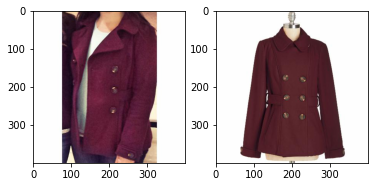

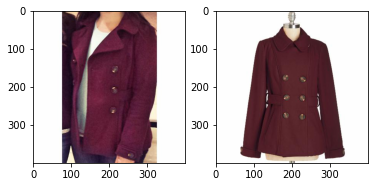

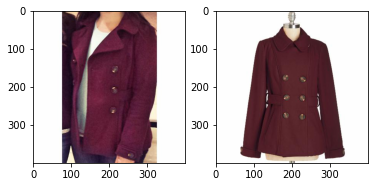

In [ ]:
idx = 1
cat = 'outerwear'
mode='train'
print(get_image_ids(cat,idx))
street_img,shop_img = get_image_pair(cat,idx,shop_entry=0,target_shape=IMG_SHAPE,mode=mode)
plt.subplot(1,2,1)
plt.imshow(0.00392156862*street_img)
plt.subplot(1,2,2)
plt.imshow(0.00392156862*shop_img)
plt.show()
street_img,shop_img = get_image_pair(cat,idx,shop_entry=0,mode=mode)
plt.subplot(1,2,1)
plt.imshow(0.00392156862*street_img)
plt.subplot(1,2,2)
plt.imshow(0.00392156862*shop_img)
plt.show()
street_img,shop_img = get_image_pair(cat,idx,shop_entry=0,use_bbox=False,fromMem=USE_MEM,mode=mode)
plt.subplot(1,2,1)
plt.imshow(0.00392156862*street_img)
plt.subplot(1,2,2)
plt.imshow(0.00392156862*shop_img)
plt.show()

## An example of custom triplet loss layer and model architecture

In [6]:
from tensorflow.keras.layers import Input, Dense, Reshape, BatchNormalization,\
                                    Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.mean(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

def get_model():
    if(BACKBONE=='EfficientNetB1'):
        from tensorflow.python.keras.applications.efficientnet import EfficientNetB1,preprocess_input
        model_backbone = EfficientNetB1(weights='imagenet',include_top=False, input_shape=(244,244,3))
    elif(BACKBONE=='VGG'):
        from tensorflow.python.keras.applications.vgg16 import VGG16,preprocess_input
        model_backbone = VGG16(weights='imagenet',include_top=False, input_shape=(244,244,3))
    elif(BACKBONE=='EfficientNetB3'):
        from tensorflow.python.keras.applications.efficientnet import EfficientNetB3,preprocess_input
        model_backbone = EfficientNetB3(weights='imagenet',include_top=False, input_shape=INPUT_SHAPE)
    elif(BACKBONE=='EfficientNetB4'):
        from tensorflow.python.keras.applications.efficientnet import EfficientNetB4,preprocess_input
        model_backbone = EfficientNetB4(weights='imagenet',include_top=False, input_shape=INPUT_SHAPE)
    elif(BACKBONE=='EfficientNetB5'):
        from tensorflow.python.keras.applications.efficientnet import EfficientNetB5,preprocess_input
        model_backbone = EfficientNetB5(weights='imagenet',include_top=False, input_shape=INPUT_SHAPE)
    model_backbone.trainable = False
    x = GlobalAveragePooling2D(name="avg_pool")(model_backbone.outputs[0])
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024,activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512,activation='relu')(x)                
    x = Dropout(0.4)(x)
    x_encoding = Dense(N_ENCODING)(x)
    x_encoding = K.l2_normalize(x_encoding, axis=-1)
    preprocessing_fn = preprocess_input
    one_model = Model(inputs = model_backbone.inputs,outputs=x_encoding, name="EncodingMod")

    inp_a = Input(INPUT_SHAPE)
    inp_p = Input(INPUT_SHAPE)
    inp_n = Input(INPUT_SHAPE)

    x_a = one_model(inp_a)
    x_p = one_model(inp_p)
    x_n = one_model(inp_n)
    loss_layer = TripletLossLayer(alpha=MARGIN,name='triplet_loss_layer')([x_a,x_p,x_n])

    model = Model(inputs = [inp_a,inp_p,inp_n], outputs = loss_layer)
    model.summary()
    return model, preprocessing_fn

In [7]:
K.clear_session()
triplet_model,preprocessing_fn = get_model()

#triplet_model.compile(loss = triplet_loss, optimizer = 'adam')
triplet_model.compile( optimizer = 'adam')

43941888/43941136 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
EncodingMod (Functional)        (None, 128)          12954031    input_2[0][0]                    
                             

## Data generator for fitting functions

In [8]:
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity
from skimage.color import deltaE_ciede2000
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,preprocess_fn,batch_size ,negatives_other_cat_frac = 0.0,mode='train', 
                 steps = None, used_cats = classes,shuffle=True):
        'Initialization'        
        self.shuffle=shuffle
        self.preprocess_fn=preprocess_fn
        self.n_classes = N_CATEGORIES
        self.mode=mode
        self.steps = steps
        self.used_cats=used_cats
        self.batch_size = batch_size
        self.negatives_other_cat_frac =negatives_other_cat_frac
        self.used_array = train_array if mode=="train" else test_array
        self.N_GEN_PAIRS = 0
        for c in used_cats:
          self.N_GEN_PAIRS += len(self.used_array[c]) 
        print("Generator pairs: ",self.N_GEN_PAIRS)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if(self.steps is None):
          return int(np.floor(self.N_GEN_PAIRS / self.batch_size))
        else:
          return self.steps

    def __getitem__(self, index):        
        'Generate one batch of data'
        #print("Gettting batch: ",index)
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y
    def get_positive_images(self,positive_idx):
      res = None
      while(res is None):            
        pos_cat = self.used_cats[np.random.randint(0,len(self.used_cats),1)[0]]      
        positive_idx = np.random.randint(0,len(self.used_array[pos_cat]),1)[0]        
        #print("Pos gen idx/cat : ",positive_idx,"  ", pos_cat)
        res = get_image_pair(pos_cat,positive_idx,shop_entry=0, mode=self.mode,target_shape=IMG_SHAPE,use_bbox = True,fromMem=USE_MEM)
        if(res is None):
          positive_idx = np.random.randint(0,len(self.used_array[pos_cat]),1)[0]
          continue        
      return res, pos_cat        
    def get_negative_image(self,positive_idx, pos_cat):
      img = None
      while(img is None):
        neg_category = pos_cat if np.random.binomial(1,1-self.negatives_other_cat_frac,1) else self.used_cats[np.random.randint(0,len(self.used_cats),1)[0]]        
        neg_idx = np.random.randint(0,len(self.used_array[neg_category]),1)[0]
        #print("Neg gen idx/cat : ",neg_idx,"  ",neg_category)
        if(neg_idx == positive_idx):
          continue
        res = get_image_ids(neg_category,neg_idx,mode=self.mode)
        if(res is None):
          continue
        _, _, shop_ids = res
        if USE_MEM:
          img = loadImageFromMem(shop_ids[0],neg_idx, neg_category,mode=self.mode)
        else:
          img = loadImage(photo_urls[shop_ids[0]][1], neg_category, target_shape=IMG_SHAPE)
        
      return img
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.N_GEN_PAIRS)  
        if(self.shuffle==True)      :
          np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        bs = len(indexes)
        X_img_a = np.empty((bs,)+INPUT_SHAPE)
        X_img_p = np.empty((bs,)+INPUT_SHAPE)
        X_img_n = np.empty((bs,)+INPUT_SHAPE)
        for i in range(bs):          
          [street_p_img, shop_p_img], pos_cat = self.get_positive_images(indexes[i])
          shop_n_img = self.get_negative_image(indexes[i],pos_cat)
          X_img_a[i] = self.preprocess_fn(street_p_img)
          X_img_p[i] = self.preprocess_fn(shop_p_img)
          X_img_n[i] = self.preprocess_fn(shop_n_img)
        X = [X_img_a,X_img_p,X_img_n]
        y = np.empty((bs,3,N_ENCODING))
        return X,y




In [ ]:
used_cats = ["dresses","tops","skirts","outerwear"]
train_gen = DataGenerator(preprocess_fn=preprocessing_fn,batch_size=BATCH_SIZE,negatives_other_cat_frac = 0.0,
                          mode='train',used_cats=used_cats)
val_gen = DataGenerator(preprocess_fn=preprocessing_fn,batch_size=BATCH_SIZE,negatives_other_cat_frac = 0.0,
                        mode='test',used_cats=used_cats,shuffle=False)

Generator pairs:  20330
Generator pairs:  5325


## Define callbacks and fit the model, while loading previous weights if possible

In [9]:
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
CHECKPOINT_DIR = DRIVE_DIR+'/checkpoints/s2s_'+BACKBONE+"_"+str(INPUT_SHAPE[0])+"_"+str(N_ENCODING)+"_"+str(MARGIN)[2:]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.316, patience=3)
earlyStop = EarlyStopping(patience=6,monitor='val_loss',restore_best_weights=True)
checkpoint =ModelCheckpoint(CHECKPOINT_DIR+'.ckpt',save_weights_only=True,verbose=1,save_best_only=True,monitor='val_loss')
callbacks = [earlyStop,checkpoint,reduce_lr]

In [ ]:
triplet_model.load_weights(CHECKPOINT_DIR)

In [ ]:
triplet_model.fit(train_gen,epochs=100,batch_size=BATCH_SIZE,validation_data=val_gen,callbacks=callbacks,workers=4)

In [ ]:
triplet_model.save_weights(CHECKPOINT_DIR+".h5")